# Sudoku Solver Project with Deep Learning 
### By Sharon Eliyahu

# Import libreries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# GPU search & colab 

In [2]:
# %tensorflow_version 2.x
# import tensorflow as tf

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name),tf.__version__)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# Import the Data

In [4]:
data  = pd.read_csv('sudoku.csv')
data.head()

,quizzes,solutions
0,0043002090050090010700600430060020871900074000...,8643712593258497619712658434361925871986574322...
1,0401000501070039605200080000000000170009068008...,3461792581875239645296483719658324174729168358...
2,6001203840084590720000060050002640300700800069...,6951273841384596727248369158512647392739815469...
3,4972000001004000050000160986203000403009000000...,4972583161864397252537164986293815473759641828...
4,0059103080094030600275001000300002010008200070...,4659123781894735623275681497386452919548216372...


# Clean data if needed , convert board to array

In [5]:
def convert_board(x):
    try:
        # gets str ['9999999'] ,splits it ,and returns array of int  -> [9,9,9,9,9,9,9,9] or null if failed
        x = list(map(int,x))
        return np.array(x) 
    except ValueError:
        return np.nan

In [6]:
data = data.applymap(lambda x: convert_board(x))
data.dropna(inplace=True)

# Split X&Y and reshaping data

In [7]:
x_data = data['quizzes']
y_data = data['solutions']

In [8]:
x_data[0]

array([0, 0, 4, 3, 0, 0, 2, 0, 9, 0, 0, 5, 0, 0, 9, 0, 0, 1, 0, 7, 0, 0,
       6, 0, 0, 4, 3, 0, 0, 6, 0, 0, 2, 0, 8, 7, 1, 9, 0, 0, 0, 7, 4, 0,
       0, 0, 5, 0, 0, 8, 3, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 0, 5, 0, 0, 3,
       5, 0, 8, 6, 9, 0, 0, 4, 2, 9, 1, 0, 3, 0, 0])

In [9]:
x_data = np.hstack(x_data)
y_data = np.hstack(y_data)

In [10]:
x_data = x_data.reshape(-1,9,9)
y_data = y_data.reshape(-1,81)

# Apply to_categorical on Y Data

In [11]:
from tensorflow.keras.utils import to_categorical

In [12]:
# I added the -1 to get only 9 Labels, because 0-9 has 10 categories
y_data = to_categorical(y_data - 1) 

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=0.1, random_state = 42)

# Normalize the X Data

In [15]:
# sudoku has only numbers in range 1-9 , so we can divide all numbers by 9
# and if we subtracting 0.5 we can make it 0 mean
# which is better for the system and can help to the accuracy

def normalize_data(x):
    return np.array(x / 9) - 0.5

def denormalize_data(x):
    return (x + 0.5)  * 9

In [16]:
X_train = normalize_data(X_train.reshape(-1,9,9,1))
X_test = normalize_data(X_test.reshape(-1,9,9,1))

# Building the model

In [17]:
# After building several models this is my optimal model.
# I inserted the game shape layer as 1,9,9,1
# After that, taking into account the sudoku rules and the input shape, I added several
# convolution layers with 64 filters in different shapes.
# I used the 'Relo' activation to get a result between 0 and 1.
# I then summed with a 1,1 convolution layer and 128 filters to get a layer 
# for each number on the board
# After each layer I normalized the result with BatchNormalization() to get closer to 0 or 1
# After the convolution layers I turned everything into 1D with Flatten.
# Because we have 81 numbers to predict and each number has 9 different lables 
# The output layer will be 81*9 in a shape of 81,9 with softmax activation
# to get a probability result between 0-1 for each of the labels.
# I use categorical_crossentropy because I want to do multi-classification 
# and I have more than one label.

import keras
from keras.layers import Activation
from keras.layers import Conv2D, BatchNormalization, Dense, Flatten, Reshape, Dropout

model = keras.models.Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(9,9,1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(1,9), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(9,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(81*9))
model.add(Reshape((-1, 9)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 64)          640       
                                                                 
 batch_normalization (BatchN  (None, 9, 9, 64)         256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 batch_normalization_1 (Batc  (None, 9, 9, 64)         256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 batch_normalization_2 (Batc  (None, 9, 9, 64)         2

# Training the model

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
#EarlyStopping is used to help avoid over fitting and wasting time
# by stopping the training when the monitor cant get any better from epoch to epoch
early_stop = EarlyStopping(monitor='val_loss',patience=2,verbose=1)

In [21]:
# Because my data is large, I use a batch size that is quite large.
# The advantage is that the system will learn the data faster. 
# Validation loss will vary more proportionally.
# Something that will help stop the train in a more optimal point

In [22]:
#model.fit(X_train,Y_train,epochs=30,batch_size=256, validation_data=(X_test,Y_test),callbacks=[early_stop])

# Saving and evaluate the model

In [23]:
#model.save('sudoku_model.h5')

In [24]:
#history = pd.DataFrame(model.history.history)

In [25]:
#history.to_csv('sudoku_model.csv')

In [26]:
history = pd.read_csv('sudoku_model.csv')

# We can see that the val_loss get to its minimal point and stops 
# so we are not in overfit :)
# and the model is pretty accurate

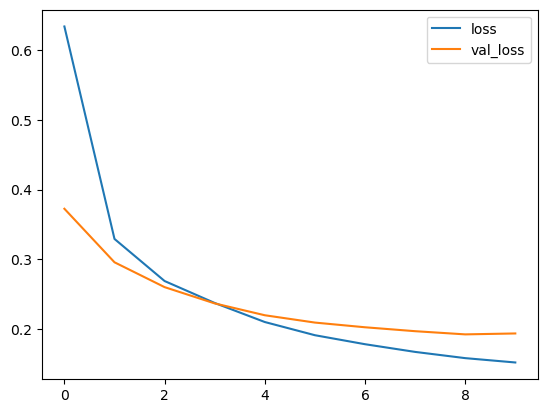

In [27]:
plt.plot(history[['loss','val_loss']])
plt.legend(['loss','val_loss'])

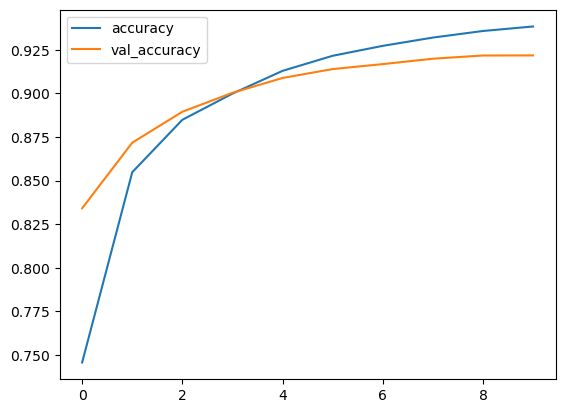

In [28]:
history[['accuracy','val_accuracy']].plot()
plt.legend(['accuracy','val_accuracy'])

# Load model and functions

In [29]:
from tensorflow.keras.models import load_model
l_model = load_model('sudoku_model.h5')

In [30]:
l_model.evaluate(X_test,Y_test)

3125/3125 [==============================] - 37s 12ms/step - loss: 0.1938 - accuracy: 0.9218


[0.19381727278232574, 0.921787679195404]

In [31]:
def prob(x, minimum = 0.99):
    if x > minimum:
        return 1
    else:
        return 0

In [32]:
def print_board(array):
    s = ''''''
    array = array.astype(int)
    for i in range(0,array.shape[0],3):
        s = s + str(array[i:i+3])  
        if (i + 3) % 9 == 0 and i > 0:
            s = s + '\n'
        else:
            s = s + ' | '
        if (i + 3) % 27 == 0 and i < 78:
            s = s + '- - - - - - - - - - -\n'
    print(s.replace('[',"").replace(']',""))

In [33]:
def predict(game,prob_rate):
# this function gets an array of a sudoku game ,normalize it and predict it
# I have set a minimum to the hottest vectors in the main function in order to control it during the pred sycels
# whats under the minimum will return 0 , in order to return 0 we have to add a '0' catagory 
# becuase we only have 1-9 catagories. only we can control the 0 label , the system will keep returning 9 labels
    game = normalize_data(game)
    game = game.reshape(1,9,9,1)
    pred = l_model.predict(game,verbose=0).reshape(81,9)
    pred = pd.DataFrame(pred).applymap(lambda x: prob(x, prob_rate))
    pred = np.concatenate((np.zeros(81).reshape(81,1), pred), axis=1)
    pred = np.argmax(np.array(pred),axis=1) 
    return pred

In [34]:
def solve_game(game,as_string=False):
#this function gets an array of 81 numbers that are an unsolved sudoku game, and returns a
#solved\unsolved game as array of 81 numbers.
# in order to increase our accuarcy we need to predict several times the board and set a minimum to the hottest vectors,
# and each time get closer to the answare by getting only numbers that has at least 99 % probebility to be true for start.
# and then lower the probability dynamically.
# if the system won't be able to solve, the loop will break after 4 diffrent predicts sycle.
# each sycle tries 20 predictions. in every prediction the the minimum will decreese by 0.5.
# and in each predict sycle, the start minimum will decreese by 4% to allow more predictions.
    if as_string:
        game = convert_board(game)       
    board = game
    board = board.reshape(81)
    unsoloved = True
    count = 0
    tries = 0
    success = False
    prob_min = 0.99
    #mask the board in order to keep quizs pos
    mask = np.ma.masked_array(board, mask= board == 0)
    s_mask = np.ma.sum(mask == board)
    while unsoloved:
        pred = predict(board , prob_min)
        prob_min -= 0.005
        pos_check = (mask == pred)
        #sum the number of true positions
        s_pos_check = np.ma.sum(pos_check)
        count += 1
        #if the game is solved the sum of each column and row is 45
        #sum the number of true columns and rows (if the sum of the col or row is 45 so return True)
        #we have to get 9 true cols and 9 true rows
        col = sum(np.unique(pred.reshape(9,9),axis=1)) == 45
        row = sum(np.unique(pred.reshape(9,9),axis=0)) == 45
        if col.sum() == row.sum() == 9 and s_mask == s_pos_check:
            unsoloved = False 
            success = True
            if as_string:
                print_board(pred.reshape(81))
                return 'Solved'
            return pred, success
        elif count > 20:
            if tries > 4:
                unsoloved = False
                success = False
                return game, success
            else:
                tries += 1
                prob_min = 0.99 - (tries * 0.04)
                count = 0
                board = game
        else:
            board = pred
            
    

# Solve 1 String game

In [35]:
#if giving a string MUST give as_string =True
game = '000700096003069178007200500075000000901000300000000000009000001318020407240005000'
solve_game(game,as_string=True)

1 8 4 | 7 5 3 | 2 9 6
5 2 3 | 4 6 9 | 1 7 8
6 9 7 | 2 8 1 | 5 4 3
- - - - - - - - - - -
8 7 5 | 3 1 2 | 9 6 4
9 6 1 | 5 4 7 | 3 8 2
4 3 2 | 6 9 8 | 7 1 5
- - - - - - - - - - -
7 5 9 | 8 3 4 | 6 2 1
3 1 8 | 9 2 6 | 4 5 7
2 4 6 | 1 7 5 | 8 3 9



'Solved'

# Test X Games -> can be change in total_test 
## *note ->gets a normalized data from X_test that was previously loaded
## I tested 20K games and the system were able to solve 97% of the games

In [36]:
import time
total_test = 10 #number of tests

In [37]:
tested_games = []
true_count = 0
count = 0 
tests = denormalize_data(X_test[:total_test])
for test in tests:
    s_t = time.time()
    count += 1
    print(f'Solving : {count}/{total_test} ... \n')
    pred , success= solve_game(test)
    
    if success:
        true_count += 1
        print_board(pred.reshape(81))
        tested_games.append(time.time() - s_t) 
        print("successed in total time: ",round(time.time() - s_t,2), " seconds")
    else:
        print(f'Failed at game {count}')
    print('tested games accuarcy: ', round(true_count / count * 100,2),'%')
    if true_count > 0:
        print(f'Average time to solve 1 game true: {round(sum(tested_games) / true_count,2)} seconds \n')
    


Solving : 1/10 ... 

6 2 4 | 5 1 3 | 7 9 8
7 8 5 | 2 4 9 | 3 1 6
9 1 3 | 7 8 6 | 4 5 2
- - - - - - - - - - -
8 3 2 | 9 6 1 | 5 4 7
5 7 9 | 3 2 4 | 8 6 1
4 6 1 | 8 7 5 | 2 3 9
- - - - - - - - - - -
1 4 7 | 6 3 2 | 9 8 5
3 9 8 | 1 5 7 | 6 2 4
2 5 6 | 4 9 8 | 1 7 3

successed in total time:  0.94  seconds
tested games accuarcy:  100.0 %
Average time to solve 1 game true: 0.94 seconds 

Solving : 2/10 ... 

2 1 6 | 9 8 4 | 5 3 7
9 5 4 | 2 3 7 | 6 8 1
7 8 3 | 5 6 1 | 9 2 4
- - - - - - - - - - -
5 6 9 | 1 4 3 | 8 7 2
1 7 2 | 6 5 8 | 4 9 3
3 4 8 | 7 2 9 | 1 6 5
- - - - - - - - - - -
6 9 5 | 3 1 2 | 7 4 8
4 2 7 | 8 9 5 | 3 1 6
8 3 1 | 4 7 6 | 2 5 9

successed in total time:  0.15  seconds
tested games accuarcy:  100.0 %
Average time to solve 1 game true: 0.55 seconds 

Solving : 3/10 ... 

8 5 1 | 2 3 9 | 4 6 7
3 4 9 | 7 6 8 | 1 5 2
6 7 2 | 5 4 1 | 3 8 9
- - - - - - - - - - -
1 2 4 | 8 5 6 | 9 7 3
9 3 6 | 1 7 2 | 5 4 8
7 8 5 | 3 9 4 | 6 2 1
- - - - - - - - - - -
5 9 3 | 4 8 7 | 2 1 6
2 6 8 | 9